In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
import joblib

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/Put/saved_single_run/"

In [2]:
#Market and option parameters as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
mu = 0.05
sigma = 0.2
tau = 1/52
T = 1/3
K = 100

#Risk measure parameteres
alpha_Glue = 0.95
beta_Glue = 0.995
omega_Glue = np.array([1/3,1/3])

In [3]:
#Sizes for (in order) training set, validation set, test set, set size for Monte Carlo estimation of the risk measures, Number of simulations used for the preliminary simulation in order to obtain an IS density
M_1 = 1500000
M_2 = 500000
M_3 = 500000
M_MC = 500000
#size of the set of data points used to calculate an IS density
M_IS = 500000
#quantile for which the IS density will be computed
alpha_IS = 0.975

In [4]:
#Calculating simulated values of S_tau and simulated payoffs P_T from simulations of standard normal random variables
def data_gen(Z,V):
    #simulate S_tau under P
    S_tau = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*Z)
    #simulate S_T given S_tau under Q
    S_T = S_tau * np.exp( (r-0.5*sigma**2)*(T-tau) + sigma*np.sqrt(T-tau)*V)
    #calculate corresponding discounted payoffs
    P_T = np.exp(-r*(T-tau)) * np.maximum(K-S_T,0)
    return S_tau, P_T

#The density function of Z
def f(y):
    return stats.norm.pdf(y, loc=0, scale=1)

#The density function of Z_\theta (note that \theta is replaced by x; this is needed for the least-squares solver to work)
def f_theta(x, y):
    return stats.norm.pdf(y, loc=x[0], scale=x[1])

#This function describes the approximation of the expression inside the sum of m_2(theta)
def g_q_alpha_hat_reweighted(x,L,q_alpha_hat):
    return np.sqrt(f(y=L[:,0])/f_theta(y=L[:,0],x=x))*(L[:,-1]>q_alpha_hat)

#bounds for the IS density parameters (for the mean parameter no bound is necessary, the standard deviation however needs to be non-negative)
bnds_lower = np.array([-np.inf,0])
bnds_upper = np.array([np.inf,np.inf])

def GlueVaR_IS(omega, L, alpha, beta, w):
    j_beta = 0
    w_sum_tmp = 0
    while(w_sum_tmp <= (1-beta)):
        w_sum_tmp += w[j_beta]
        j_beta += 1
        
    j_alpha = j_beta
    while(w_sum_tmp <= (1-alpha)):
        w_sum_tmp += w[j_alpha]
        j_alpha += 1
        
    ES_beta = 1/(1-beta) * np.sum(w[0:j_beta-1]*L[0:j_beta-1]) + ( 1 - (1 / (1-beta)) * np.sum(w[0:j_beta-1]) )*L[j_beta]
    ES_alpha = 1/(1-alpha) * np.sum(w[0:j_alpha-1]*L[0:j_alpha-1]) + ( 1 - (1 / (1-alpha)) * np.sum(w[0:j_alpha-1]) )*L[j_alpha]
    VaR_alpha = L[j_alpha]

    return omega[0]*ES_beta + omega[1]*ES_alpha + (1-omega[0]-omega[1])*VaR_alpha

In [5]:
#Generating realisations of standard normal random variables
Z_IS = np.random.normal(loc=0, scale=1, size=M_IS)
V_IS = np.random.normal(loc=0, scale=1, size=M_IS)

#Calculate the risk factor S_tau and the corresponding simulated payoffs P_T
S_tau_IS, P_T_IS = data_gen(Z=Z_IS, V=V_IS)

#define and compile neural network model, setup as in 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi_IS = np.log( np.sum(P_T_IS)/len(P_T_IS))
model_IS = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(1,)),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi_IS))])
model_IS.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_IS.fit(x=S_tau_IS, y=P_T_IS, epochs=40, batch_size=10000, verbose=0)

#Calculate realisations of L_hat from the training data set using the trained neural network
L_hat_IS = np.column_stack((Z_IS, model_IS.predict(S_tau_IS)[:,0]))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_IS_hat = L_hat_IS_sort[int(M_IS*(1-alpha_IS)), -1]

#Calculating the (hopefully) approximately optimal \theta^*_{NN} by minimising m_2 using the approximated g
IS_NN = optimize.least_squares(g_q_alpha_hat_reweighted, x0=np.array([0,1]), bounds=(bnds_lower,bnds_upper), args=(L_hat_IS_sort, q_alpha_IS_hat)).x

#define and train a random forest according to the optimal parameters from tuning
rfr_IS = RandomForestRegressor(n_estimators=160, criterion='squared_error', min_samples_leaf=500, bootstrap=True, verbose=0, n_jobs=-1)
rfr_IS.fit(X=S_tau_IS.reshape(-1,1), y=P_T_IS)

#Calculate realisations of L_hat from the training data set using the trained random forest
L_hat_IS = np.column_stack((Z_IS, rfr_IS.predict(S_tau_IS.reshape(-1,1))))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_IS_hat = L_hat_IS_sort[int(M_IS*(1-alpha_IS)), -1]

#Calculating the (hopefully) approximately optimal \theta^*_{RF} by minimising m_2 using the approximated g
IS_RF = optimize.least_squares(g_q_alpha_hat_reweighted, x0=np.array([0,1]), bounds=(bnds_lower,bnds_upper), args=(L_hat_IS_sort, q_alpha_IS_hat)).x

#print IS density parameters for checking
print(IS_NN)
print(IS_RF)

2021-11-13 10:52:29.390744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.4/lib64:/opt/bwhpc/common/compiler/gnu/10.2.0/lib:/opt/bwhpc/common/compiler/gnu/10.2.0/lib64:/opt/bwhpc/common/mpi/openmpi/4.1.1-gnu-10.2/lib:/opt/bwhpc/common/mpi/openmpi/4.1.1-gnu-10.2/lib64
2021-11-13 10:52:29.390770: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-13 10:52:29.390785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (uc2n398.localdomain): /proc/driver/nvidia/version does not exist
2021-11-13 10:52:29.391021: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructio

[-2.2709983   0.45488194]
[-2.04478043  0.5055222 ]


In [6]:
#Generating simulations of standard normal random variables for training set, validation set, test set, set for Monte Carlo estimation of risk measures
Z_train = np.random.normal(loc=0, scale=1, size=M_1)
V_train = np.random.normal(loc=0, scale=1, size=M_1)
Z_val = np.random.normal(loc=0, scale=1, size=M_2)
V_val = np.random.normal(loc=0, scale=1, size=M_2)
Z_test = np.random.normal(loc=0, scale=1, size=M_3)
V_test = np.random.normal(loc=0, scale=1, size=M_3)
Z_MC = np.random.normal(loc=0, scale=1, size=M_MC)
V_MC = np.random.normal(loc=0, scale=1, size=M_MC)

#calculating DT(Z,\theta^*_{NN})
Z_train_NN = Z_train*IS_NN[1] + IS_NN[0]
Z_val_NN = Z_val*IS_NN[1] + IS_NN[0]
Z_test_NN = Z_test*IS_NN[1] + IS_NN[0]
Z_MC_NN = Z_MC*IS_NN[1] + IS_NN[0]
#calculating the risk factors under the IS distribution and corresponding option prices
S_tau_train_NN, P_T_train_NN = data_gen(Z=Z_train_NN, V=V_train)
S_tau_val_NN, P_T_val_NN = data_gen(Z=Z_val_NN, V=V_val)
S_tau_test_NN, P_T_test_NN = data_gen(Z=Z_test_NN, V=V_test)
S_tau_MC_NN, P_T_MC_NN = data_gen(Z=Z_MC_NN, V=V_MC)

#calculating DT(Z,\theta^*_{RF})
Z_train_RF = Z_train*IS_RF[1] + IS_RF[0]
Z_val_RF = Z_val*IS_RF[1] + IS_RF[0]
Z_test_RF = Z_test*IS_RF[1] + IS_RF[0]
Z_MC_RF = Z_MC*IS_RF[1] + IS_RF[0]
#calculating the risk factors under the IS distribution and corresponding option prices
S_tau_train_RF, P_T_train_RF = data_gen(Z=Z_train_RF, V=V_train)
S_tau_val_RF, P_T_val_RF = data_gen(Z=Z_val_RF, V=V_val)
S_tau_test_RF, P_T_test_RF = data_gen(Z=Z_test_RF, V=V_test)
S_tau_MC_RF, P_T_MC_RF = data_gen(Z=Z_MC_RF, V=V_MC)

In [7]:
#calculating parameters for the sets B_1 and B_2
s_40 = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*stats.norm.ppf(0.4, loc=0, scale=1))
s_70 = s_0 * np.exp( (mu-0.5*sigma**2)*tau + sigma*np.sqrt(tau)*stats.norm.ppf(0.7, loc=0, scale=1))

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the neural network
B_1_NN = S_tau_test_NN < s_40
B_2_NN = S_tau_test_NN > s_70

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the random forest
B_1_RF = S_tau_test_RF < s_40
B_2_RF = S_tau_test_RF > s_70

In [8]:
#define and compile neural network model, setup as in section 4.1 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(P_T_train_NN)/len(P_T_train_NN))
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(1,)),
    tf.keras.layers.Dense(5, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#function for saving models after each epoch for later evaluation
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "Put_IS_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
#training the neural network
hist = model.fit(x=S_tau_train_NN, y=P_T_train_NN, epochs=40, batch_size=10000, validation_data=(S_tau_val_NN,P_T_val_NN), callbacks=[checkpoints])

#loading the saved models after every epoch
models_eval = []
for i in range(1,41):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "Put_IS_saved_epoch_" + str(i) + ".hdf5"))
    
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
mse_train_NN = hist.history['mse'][-1]
mse_val_NN = hist.history['val_mse'][-1]

for j in range(40):
    P_T_pred_tmp = models_eval[j].predict(S_tau_test_NN)[:,0]
    mc_tmp = P_T_pred_tmp - P_T_test_NN
    metric_a_NN.append(np.sum(mc_tmp)/len(P_T_test_NN))
    metric_b_NN.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test_NN))
    metric_c_B_1_NN.append(np.sum(mc_tmp[B_1_NN])/len(P_T_test_NN))
    metric_c_B_2_NN.append(np.sum(mc_tmp[B_2_NN])/len(P_T_test_NN))

GlueVaR_hat_NN = []

#computation of option price depending on the risk factor S_tau according to the neural network, i.e. computation of L_hat_i's
L_hat_NN = model.predict(S_tau_MC_NN)[:,0]
L_hat_c_NN = np.column_stack((Z_MC_NN, L_hat_NN))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
#step size
i = 500000/step_number

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    
    #calculation of the IS estimator for VaR
    L_hat_c_sort_NN = L_hat_c_NN[L_hat_c_NN[0:k,1].argsort()[::-1]]
    w = f(L_hat_c_sort_NN[:,0])/(k*f_theta(x=IS_NN, y=L_hat_c_sort_NN[:,0]))

    GlueVaR_hat_NN.append(GlueVaR_IS(omega=omega_Glue, L=L_hat_c_sort_NN[:,-1], alpha=alpha_Glue, beta=beta_Glue, w=w))

Epoch 1/40
150/150 [==============================] - 1s 2ms/step - loss: 63.8604 - mse: 63.8604 - val_loss: 62.6634 - val_mse: 62.6634
Epoch 2/40
150/150 [==============================] - 0s 1ms/step - loss: 58.3284 - mse: 58.3284 - val_loss: 58.8209 - val_mse: 58.8209
Epoch 3/40
150/150 [==============================] - 0s 1ms/step - loss: 57.8292 - mse: 57.8292 - val_loss: 58.2631 - val_mse: 58.2631
Epoch 4/40
150/150 [==============================] - 0s 1ms/step - loss: 57.8061 - mse: 57.8061 - val_loss: 57.8409 - val_mse: 57.8409
Epoch 5/40
150/150 [==============================] - 0s 1ms/step - loss: 57.7988 - mse: 57.7988 - val_loss: 57.7990 - val_mse: 57.7990
Epoch 6/40
150/150 [==============================] - 0s 1ms/step - loss: 57.7919 - mse: 57.7919 - val_loss: 57.7913 - val_mse: 57.7913
Epoch 7/40
150/150 [==============================] - 0s 1ms/step - loss: 57.7864 - mse: 57.7864 - val_loss: 57.7843 - val_mse: 57.7843
Epoch 8/40
150/150 [============================

In [13]:
#perform a grid search in order to find the (approximately) best hyperparameter min_samples_leaf
#values that will be checked
min_samples_leaf_list = [15,50,100,250,500,1000,1500,2000,2500,3000,3500,4000,4500,4700,4800,4900,5000,5100,5200,5300,5400,5500,5600,5700]
score_list = []

opt_param_RF = 0
opt_score = np.inf

for min_samples_leaf in min_samples_leaf_list:
    rfr_tuning = RandomForestRegressor(n_estimators=160, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
    rfr_tuning.fit(X=S_tau_train_RF.reshape(-1,1), y=P_T_train_RF)
    score = mean_squared_error(y_true=P_T_val_RF, y_pred=rfr_tuning.predict(S_tau_val_RF.reshape(-1,1)))
    score_list.append(score)
    print('min_samples_leaf: ', min_samples_leaf, ', MSE: ', score)
    if score < opt_score:
        opt_param_RF = min_samples_leaf
        opt_score = score
        print('New best!')

print('Best parameters found in grid search: ', opt_param_RF, ' with MSE ', opt_score)

min_samples_leaf:  15 , MSE:  58.59735955404847
New best!
min_samples_leaf:  50 , MSE:  56.730218685857515
New best!
min_samples_leaf:  100 , MSE:  56.25891445985165
New best!
min_samples_leaf:  250 , MSE:  55.92573858658444
New best!
min_samples_leaf:  500 , MSE:  55.81447847433745
New best!
min_samples_leaf:  1000 , MSE:  55.75996185686418
New best!
min_samples_leaf:  1500 , MSE:  55.743194068398736
New best!
min_samples_leaf:  2000 , MSE:  55.73638898260849
New best!
min_samples_leaf:  2500 , MSE:  55.731261047501484
New best!
min_samples_leaf:  3000 , MSE:  55.728609663145534
New best!
min_samples_leaf:  3500 , MSE:  55.7250248472094
New best!
min_samples_leaf:  4000 , MSE:  55.72321947737635
New best!
min_samples_leaf:  4500 , MSE:  55.72096792254235
New best!
min_samples_leaf:  4700 , MSE:  55.72074294400198
New best!
min_samples_leaf:  4800 , MSE:  55.7210300750915
min_samples_leaf:  4900 , MSE:  55.72037742263329
New best!
min_samples_leaf:  5000 , MSE:  55.72047713302902
min_s

In [14]:
#trees will be added to the random forest consecutivly in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []
metric_a_RF= []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', min_samples_leaf=int(opt_param_RF), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of metrics after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=S_tau_train_RF.reshape(-1,1), y=P_T_train_RF)
    
    mse_train_RF.append(mean_squared_error(y_true=P_T_train_RF, y_pred=rfr.predict(S_tau_train_RF.reshape(-1,1))))
    mse_val_RF.append(mean_squared_error(y_true=P_T_val_RF, y_pred=rfr.predict(S_tau_val_RF.reshape(-1,1))))
    
    P_T_pred_tmp = rfr.predict(S_tau_test_RF.reshape(-1,1))
    mc_tmp = P_T_pred_tmp - P_T_test_RF
    metric_a_RF.append(np.sum(mc_tmp)/len(P_T_test_RF))
    metric_b_RF.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test_RF))
    metric_c_B_1_RF.append(np.sum(mc_tmp[B_1_RF])/len(P_T_test_RF))
    metric_c_B_2_RF.append(np.sum(mc_tmp[B_2_RF])/len(P_T_test_RF))
    print(n,'of',n_tree_steps[-1],'trees built')

GlueVaR_hat_RF = []

#computation of option price depending on the risk factor S_tau according to the random forest, i.e. computation of L_hat_i's
L_hat_RF = rfr.predict(S_tau_MC_RF.reshape(-1,1))
L_hat_c_RF = np.column_stack((Z_MC_RF, L_hat_RF))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
#step size
i = 500000/step_number

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    
    #calculation of the IS estimator for VaR
    L_hat_c_sort_RF = L_hat_c_RF[L_hat_c_RF[0:k,1].argsort()[::-1]]
    w = f(L_hat_c_sort_RF[:,0])/(k*f_theta(x=IS_RF, y=L_hat_c_sort_RF[:,0]))

    GlueVaR_hat_RF.append(GlueVaR_IS(omega=omega_Glue, L=L_hat_c_sort_RF[:,-1], alpha=alpha_Glue, beta=beta_Glue, w=w))

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


Plots of the computed metrics a, b, c and training/validation MSEs for the neural network and the random forest with the evolving training process, i.e. the number of epochs or the number of trees added, respectively.

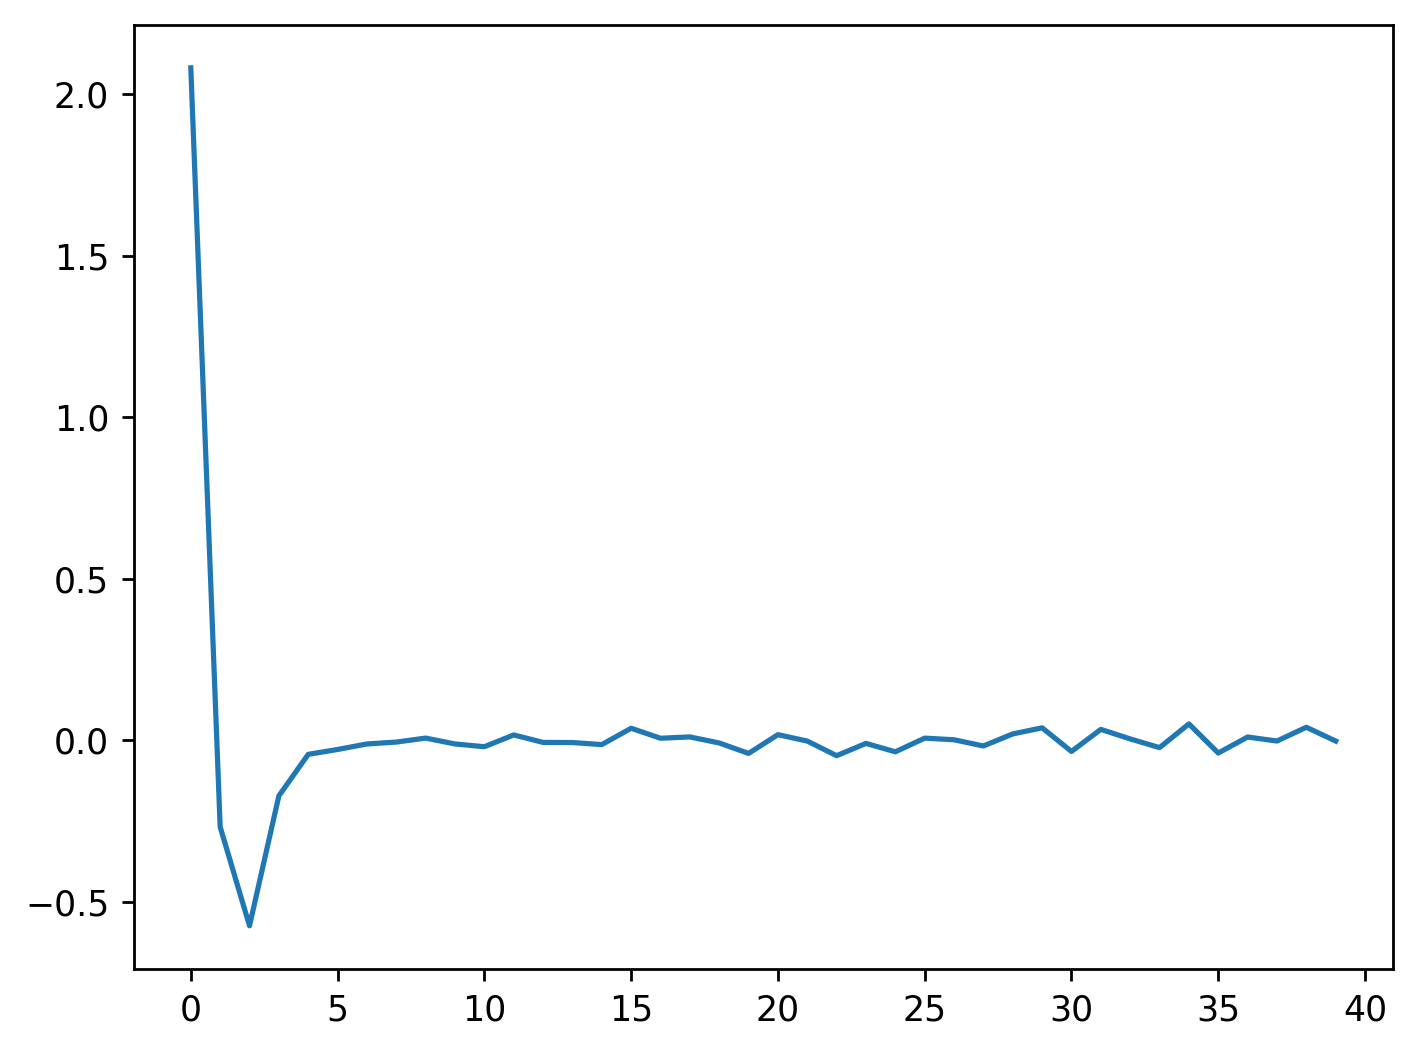

In [15]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_a_NN, color='tab:blue')
plt.show()

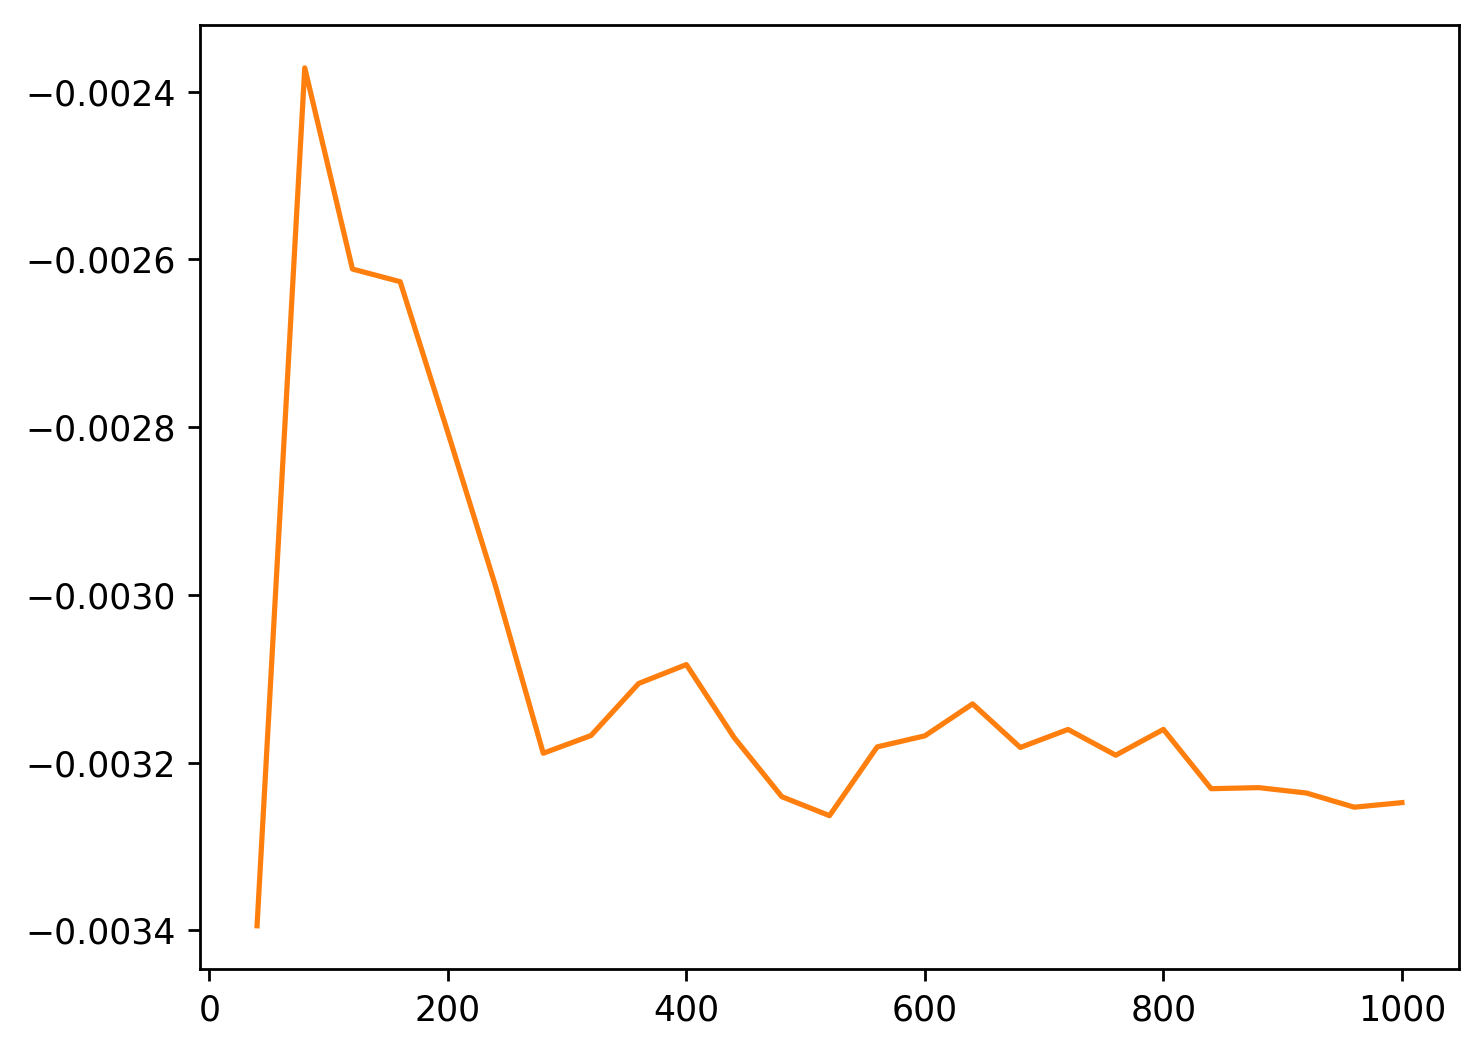

In [16]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_a_RF, color='tab:orange')
plt.show()

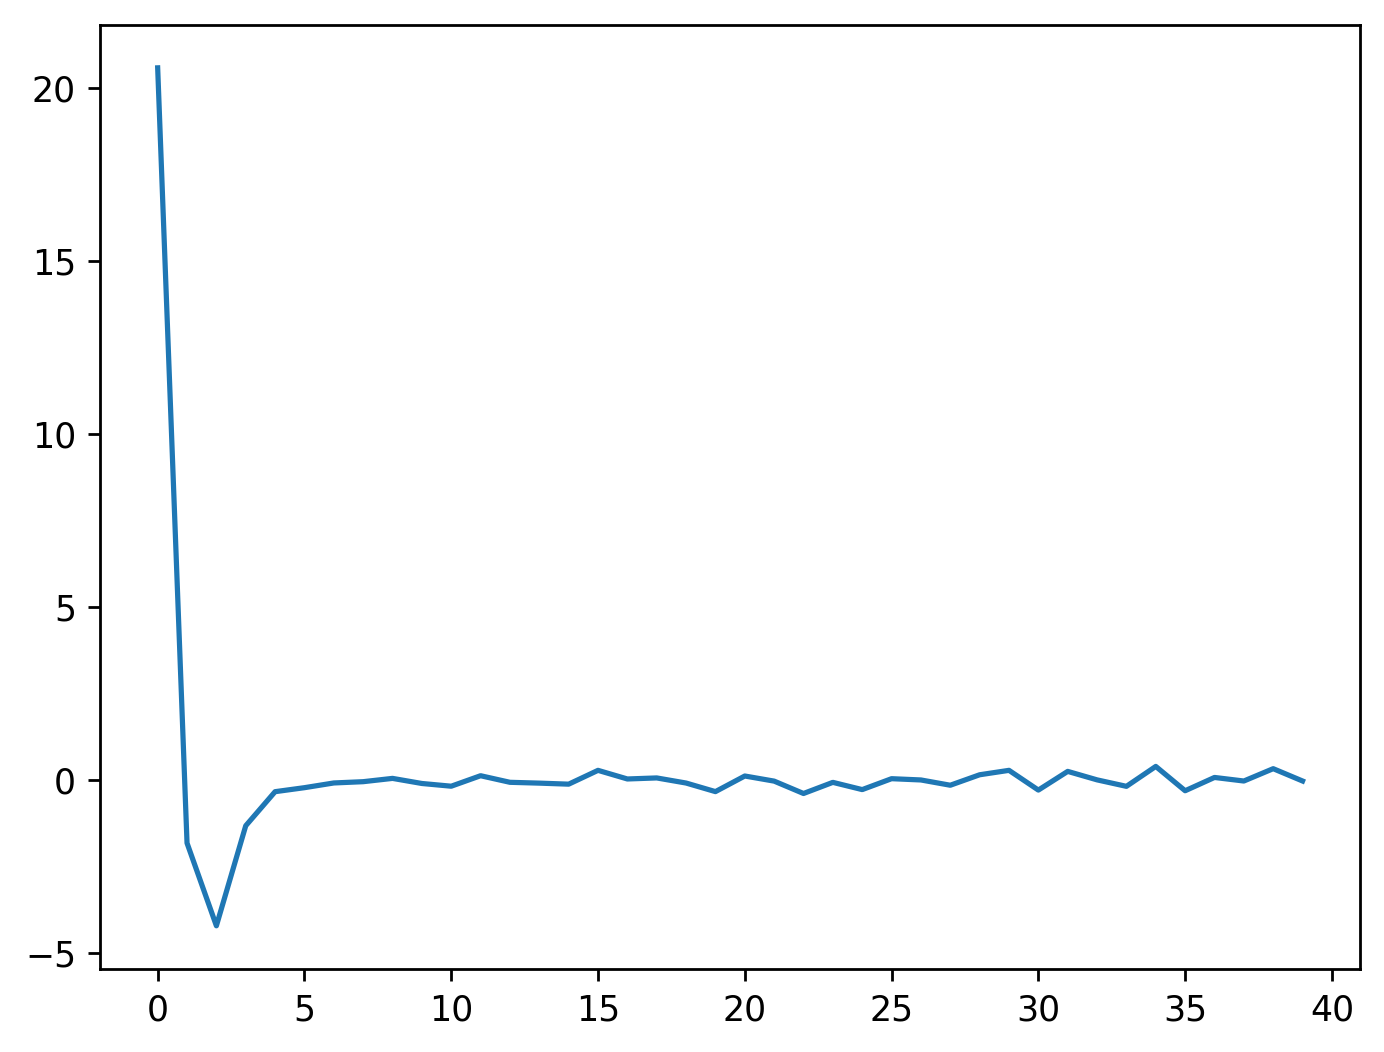

In [17]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_b_NN, color='tab:blue')
plt.show()

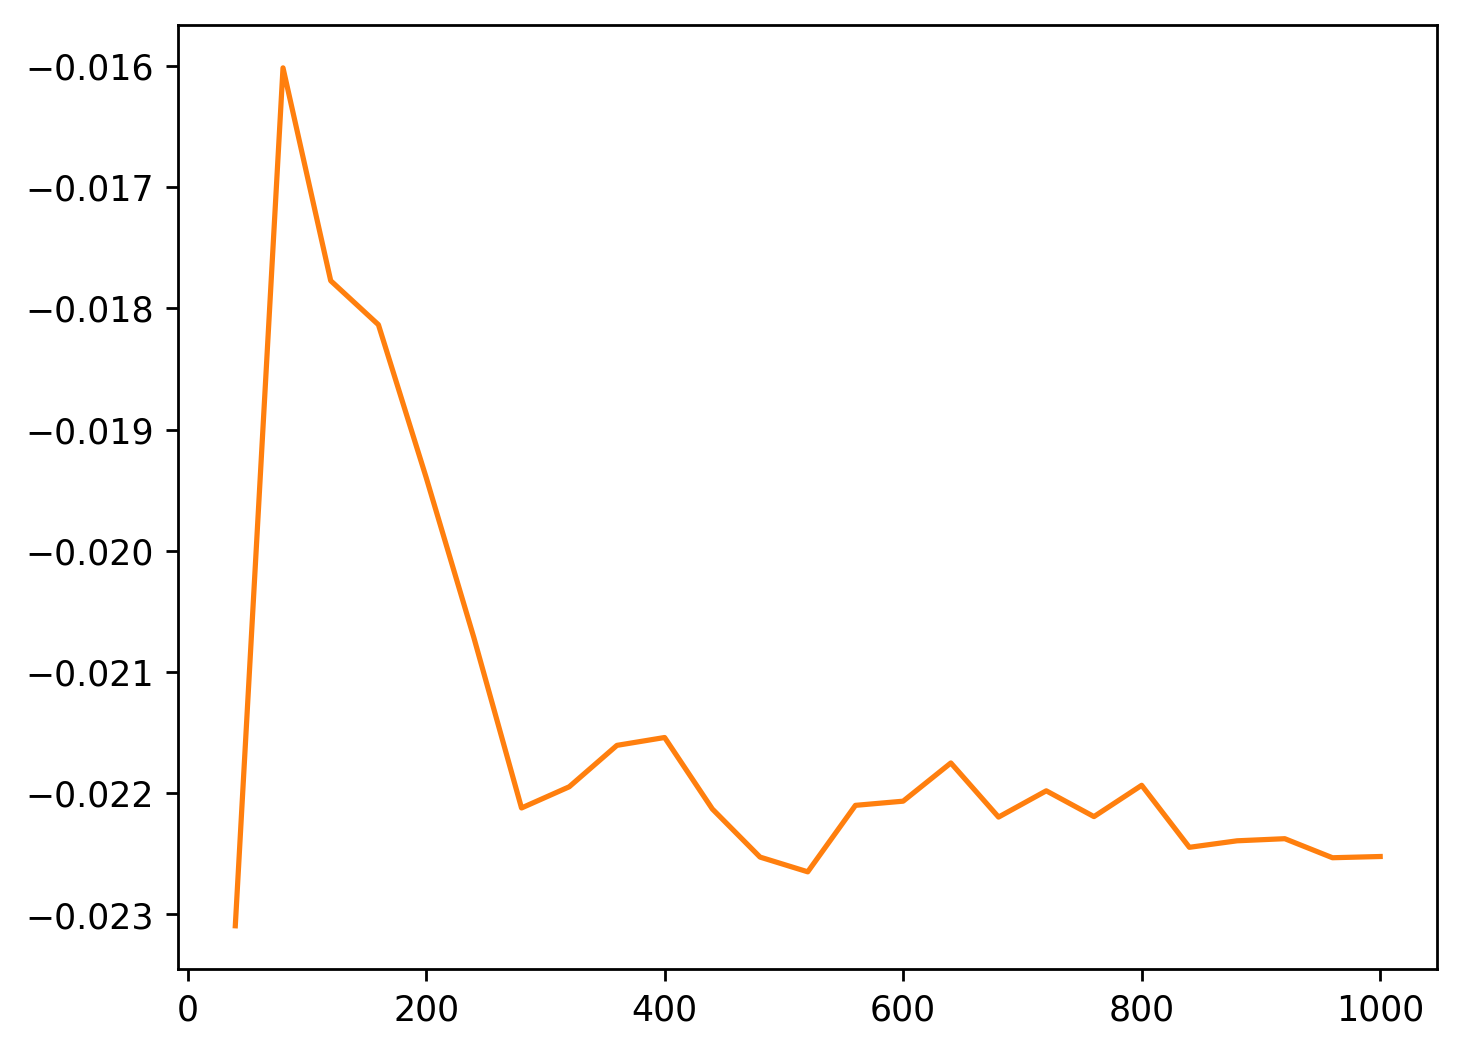

In [18]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_b_RF, color='tab:orange')
plt.show()

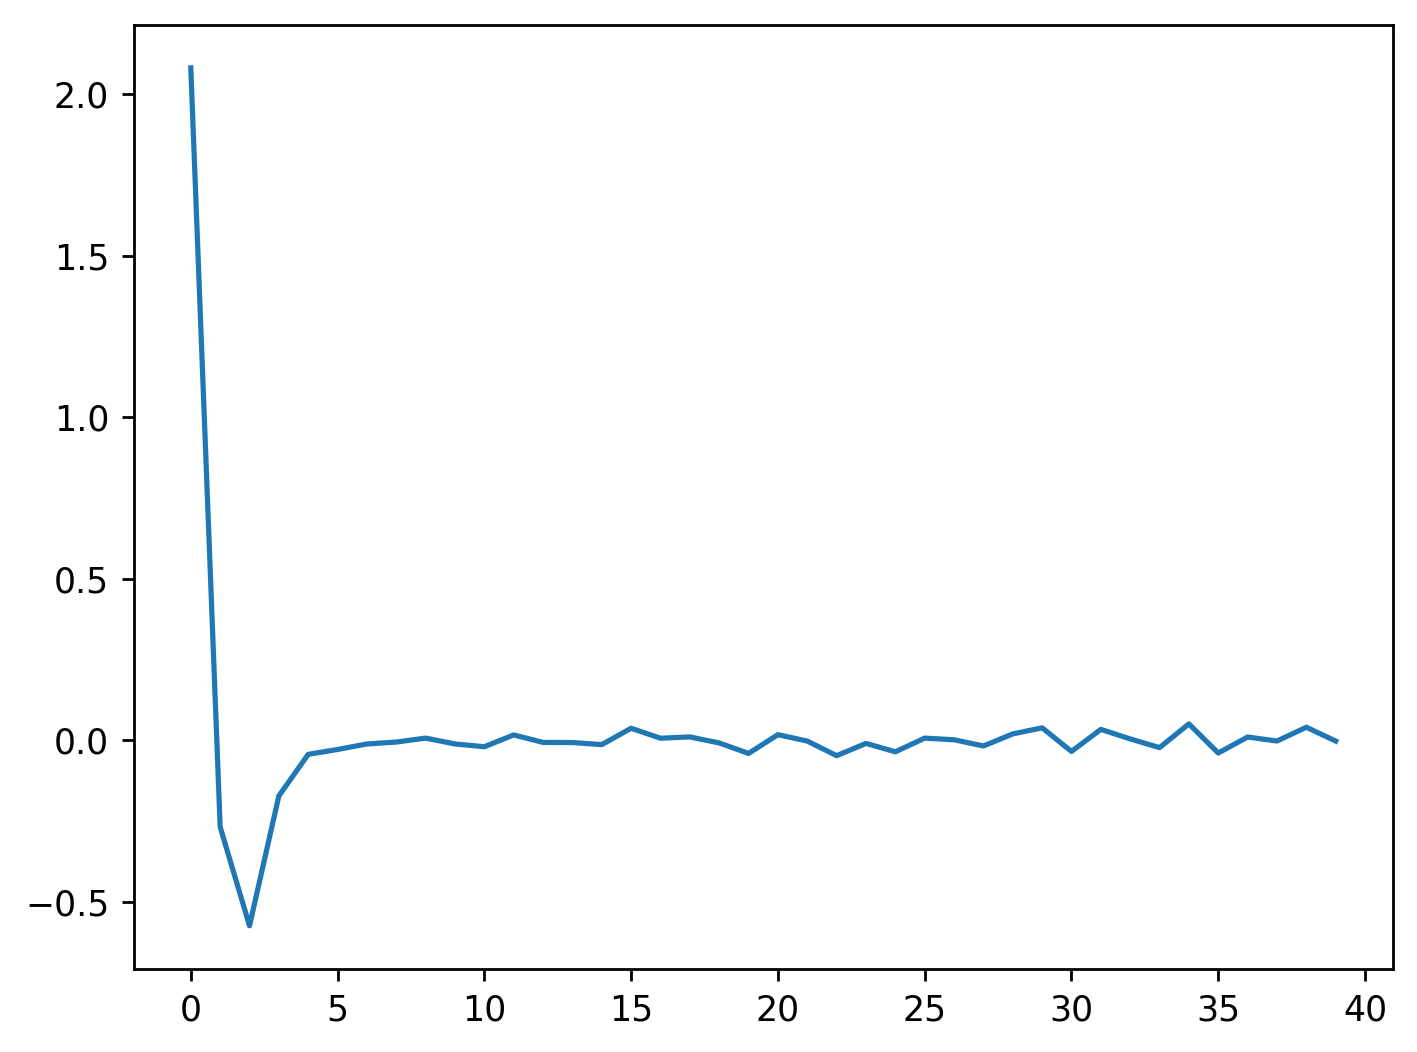

In [19]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_1_NN, color='tab:blue')
plt.show()

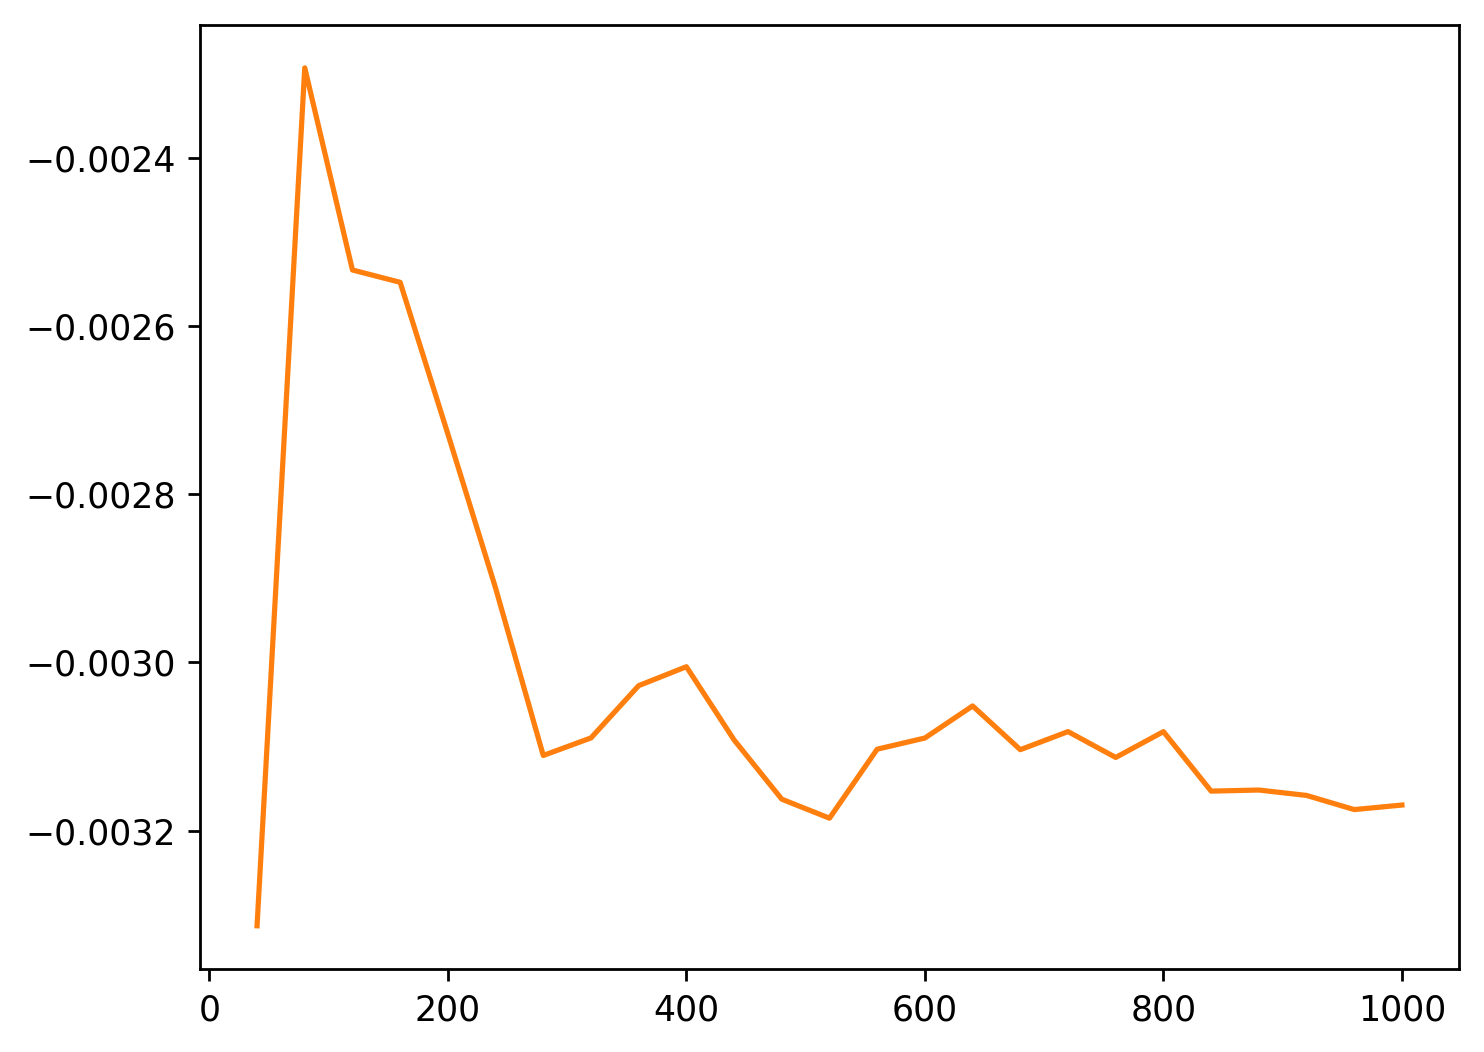

In [20]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_1_RF, color='tab:orange')
plt.show()

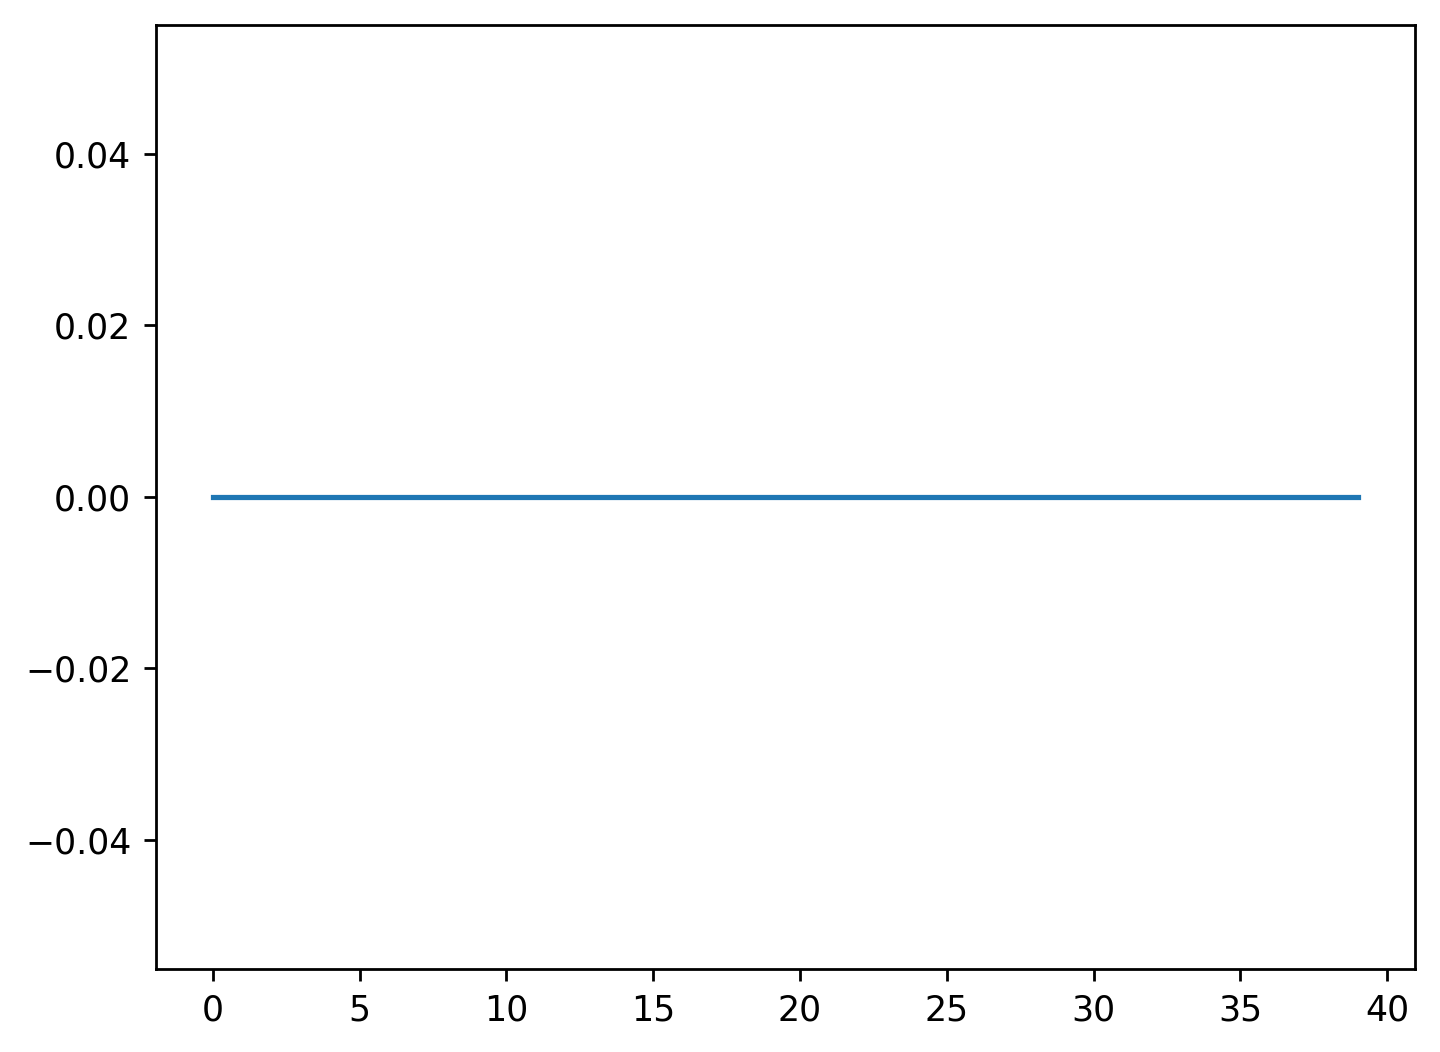

In [21]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_2_NN, color='tab:blue')
plt.show()

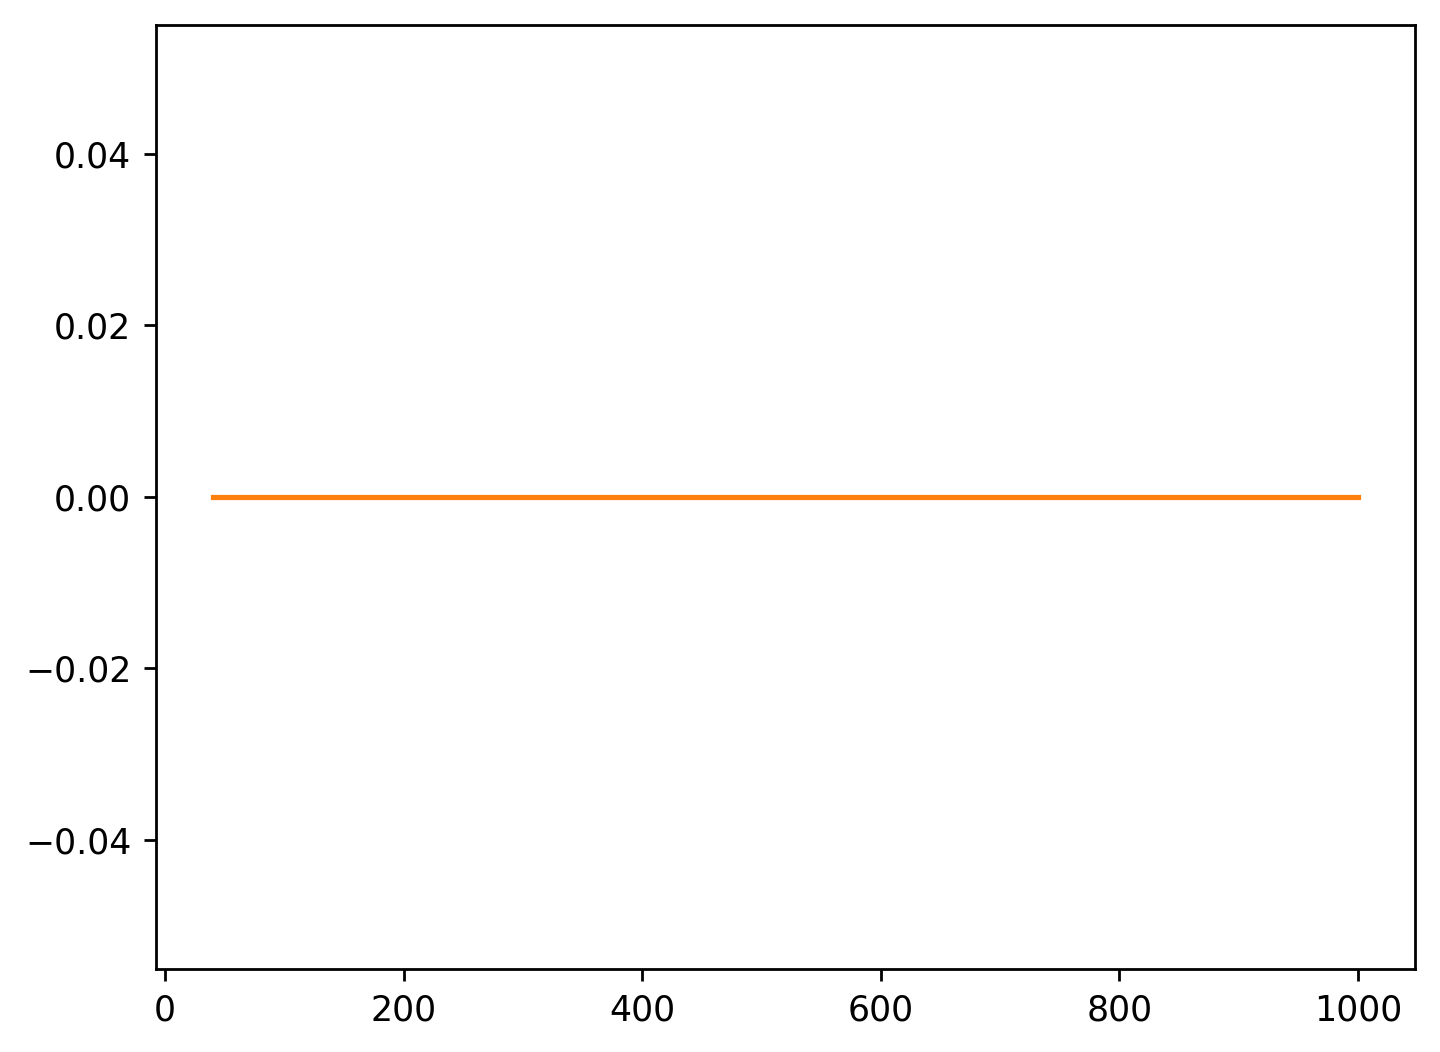

In [22]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_2_RF, color='tab:orange')
plt.show()

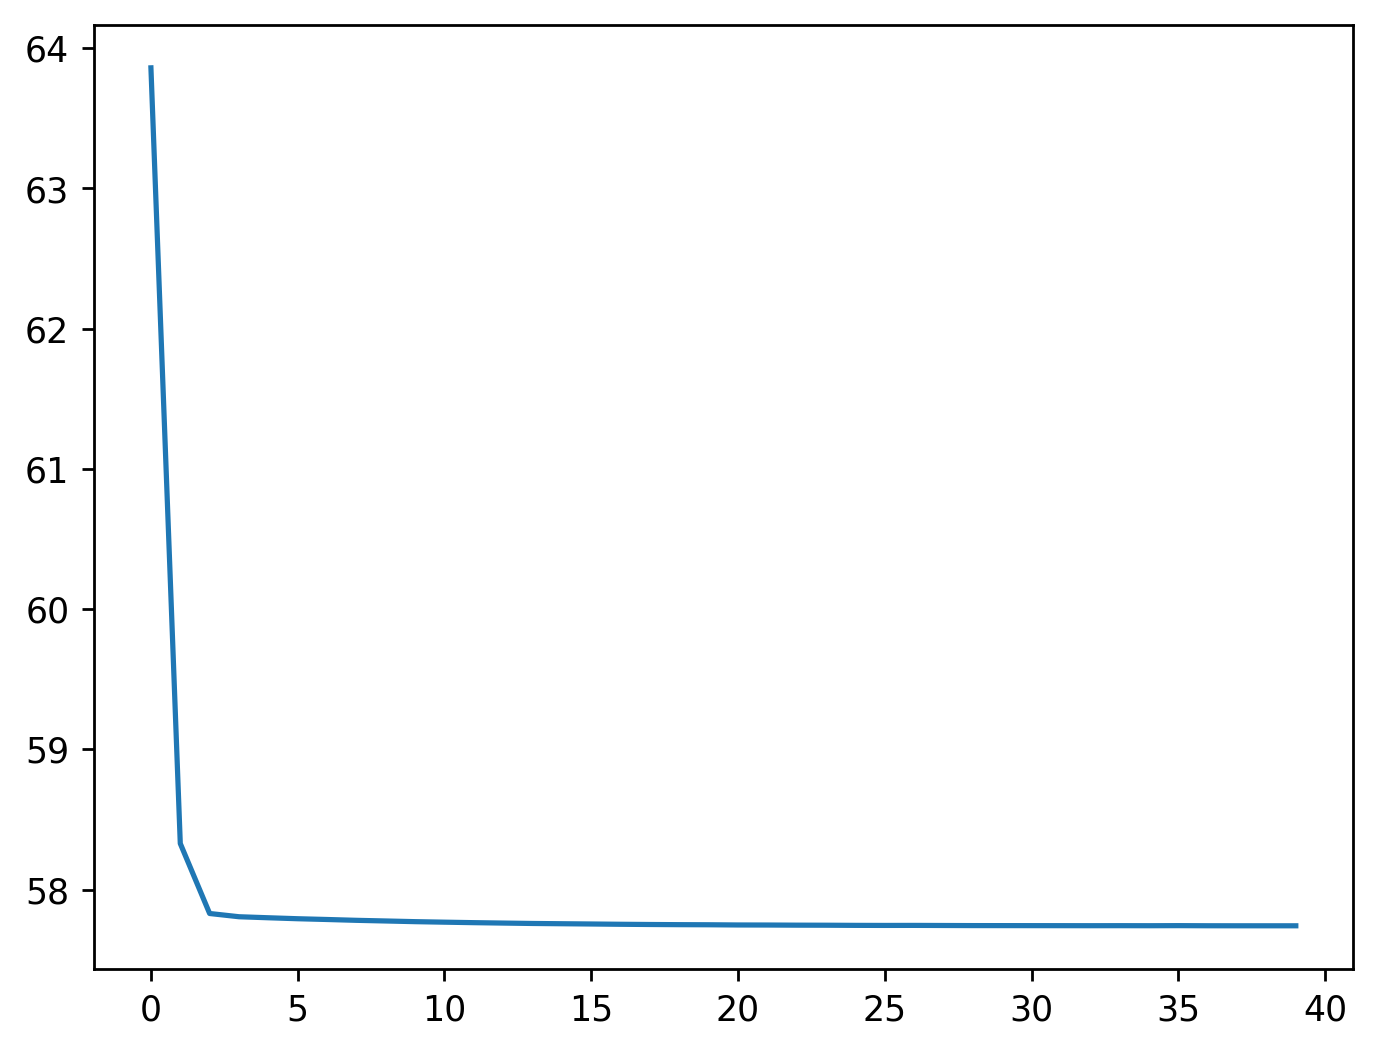

In [23]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['mse'], color='tab:blue')
plt.show()

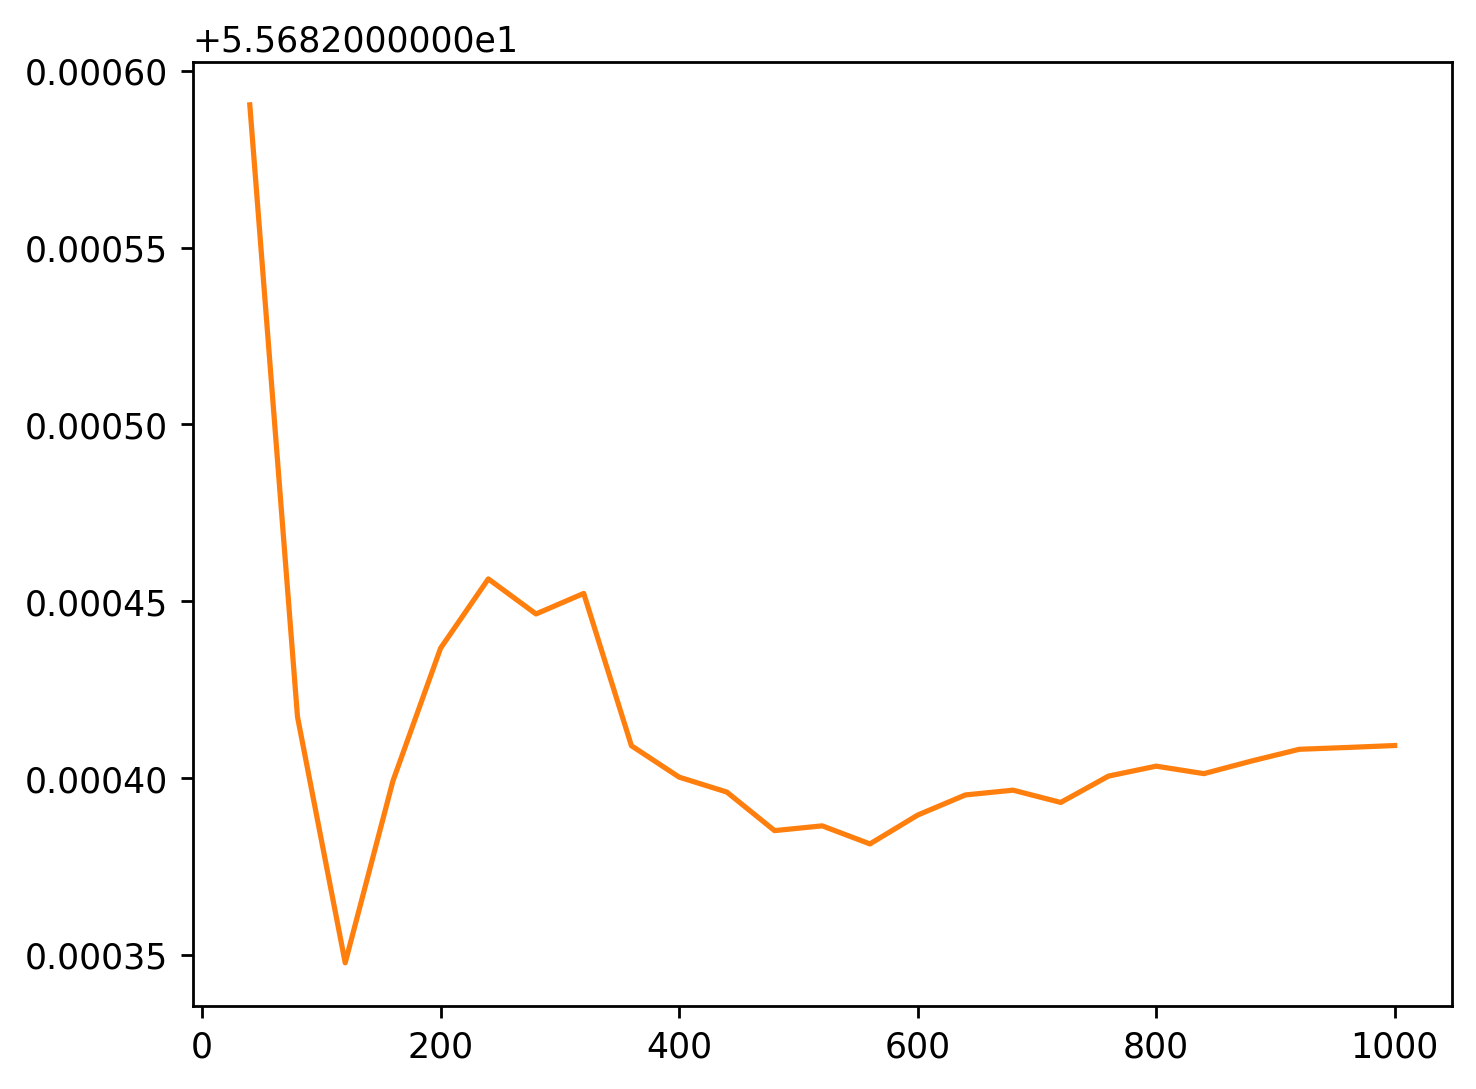

In [24]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_train_RF, color='tab:orange')
plt.show()

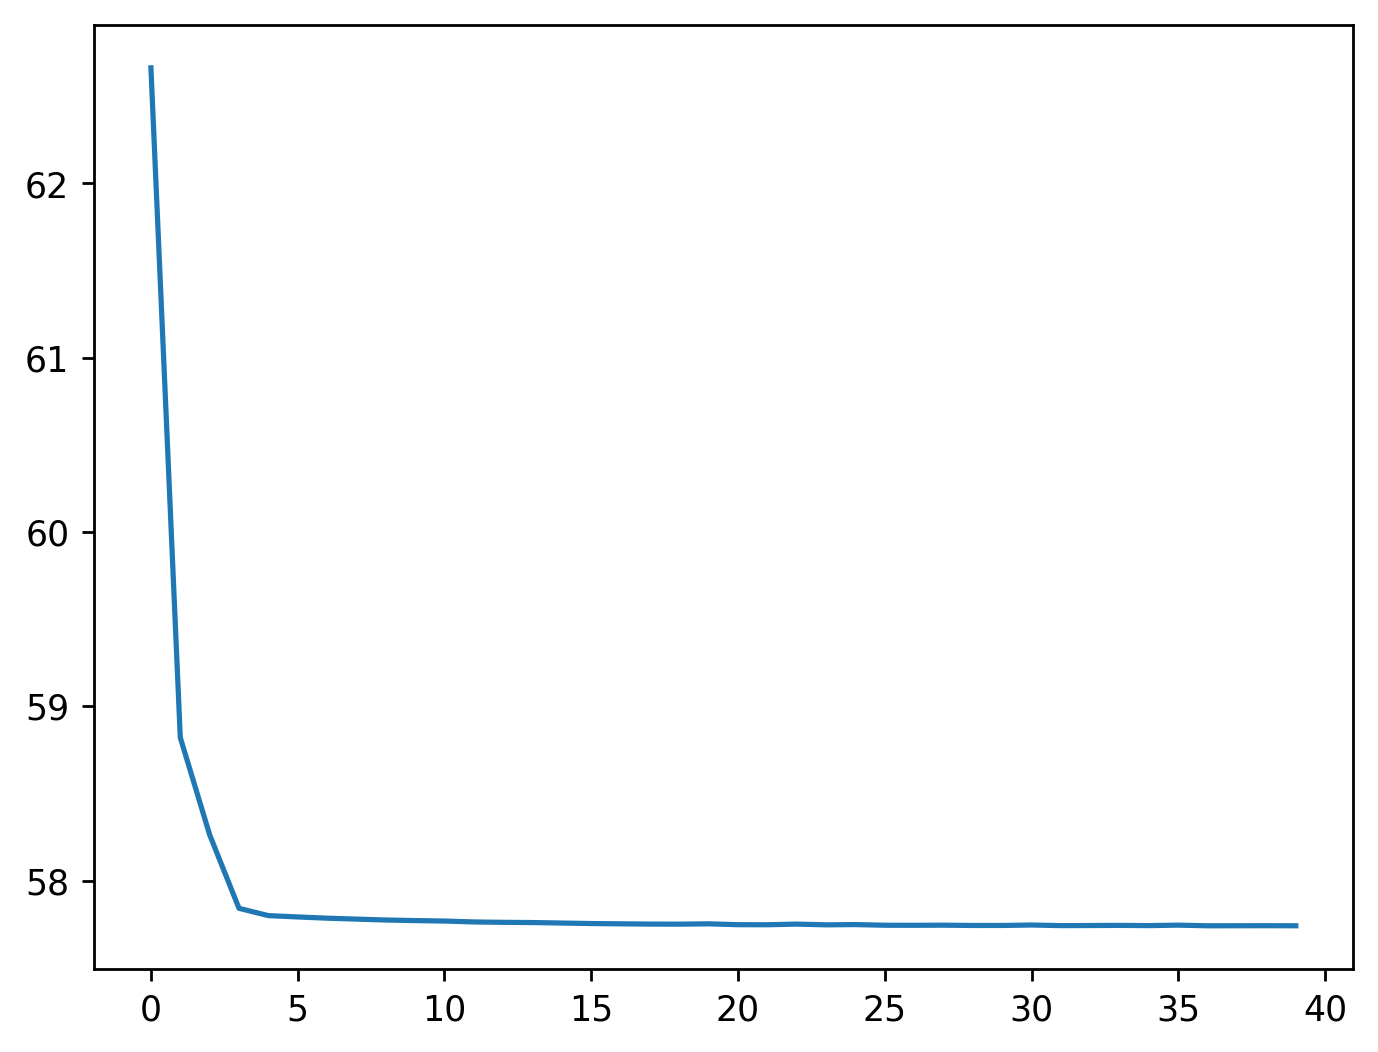

In [25]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['val_mse'], color='tab:blue')
plt.show()

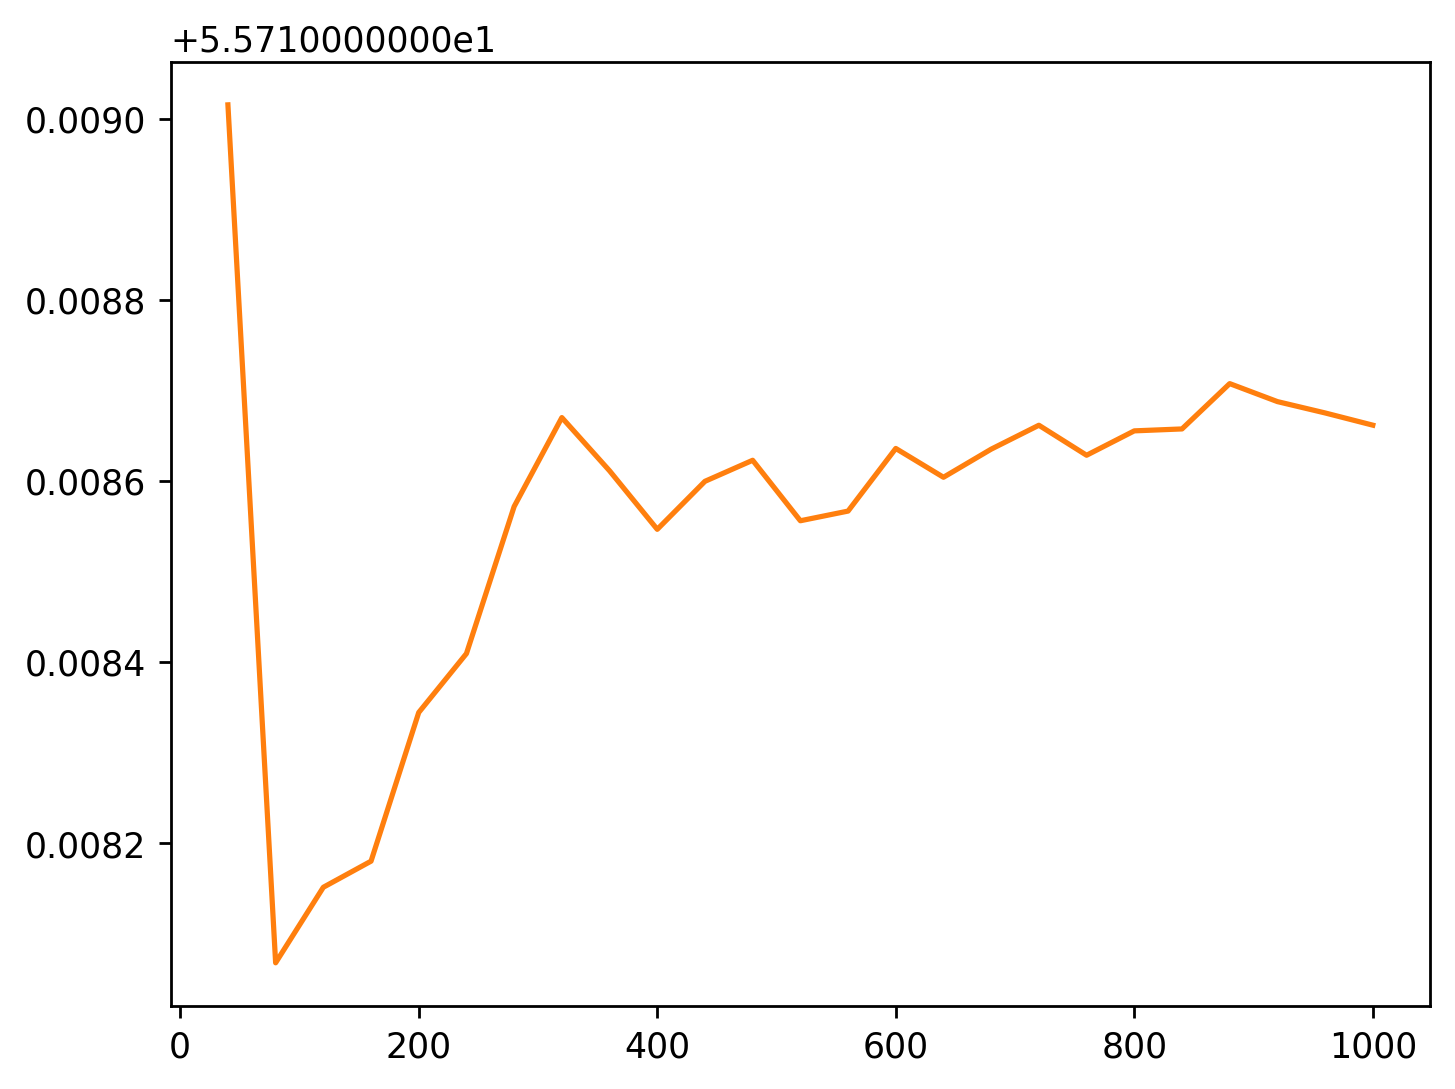

In [26]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_val_RF, color='tab:orange')
plt.show()

Plots of the risk measure estimators calculated in the stepwise procedure.

In [27]:
steps = np.linspace(i, 500000, step_number)

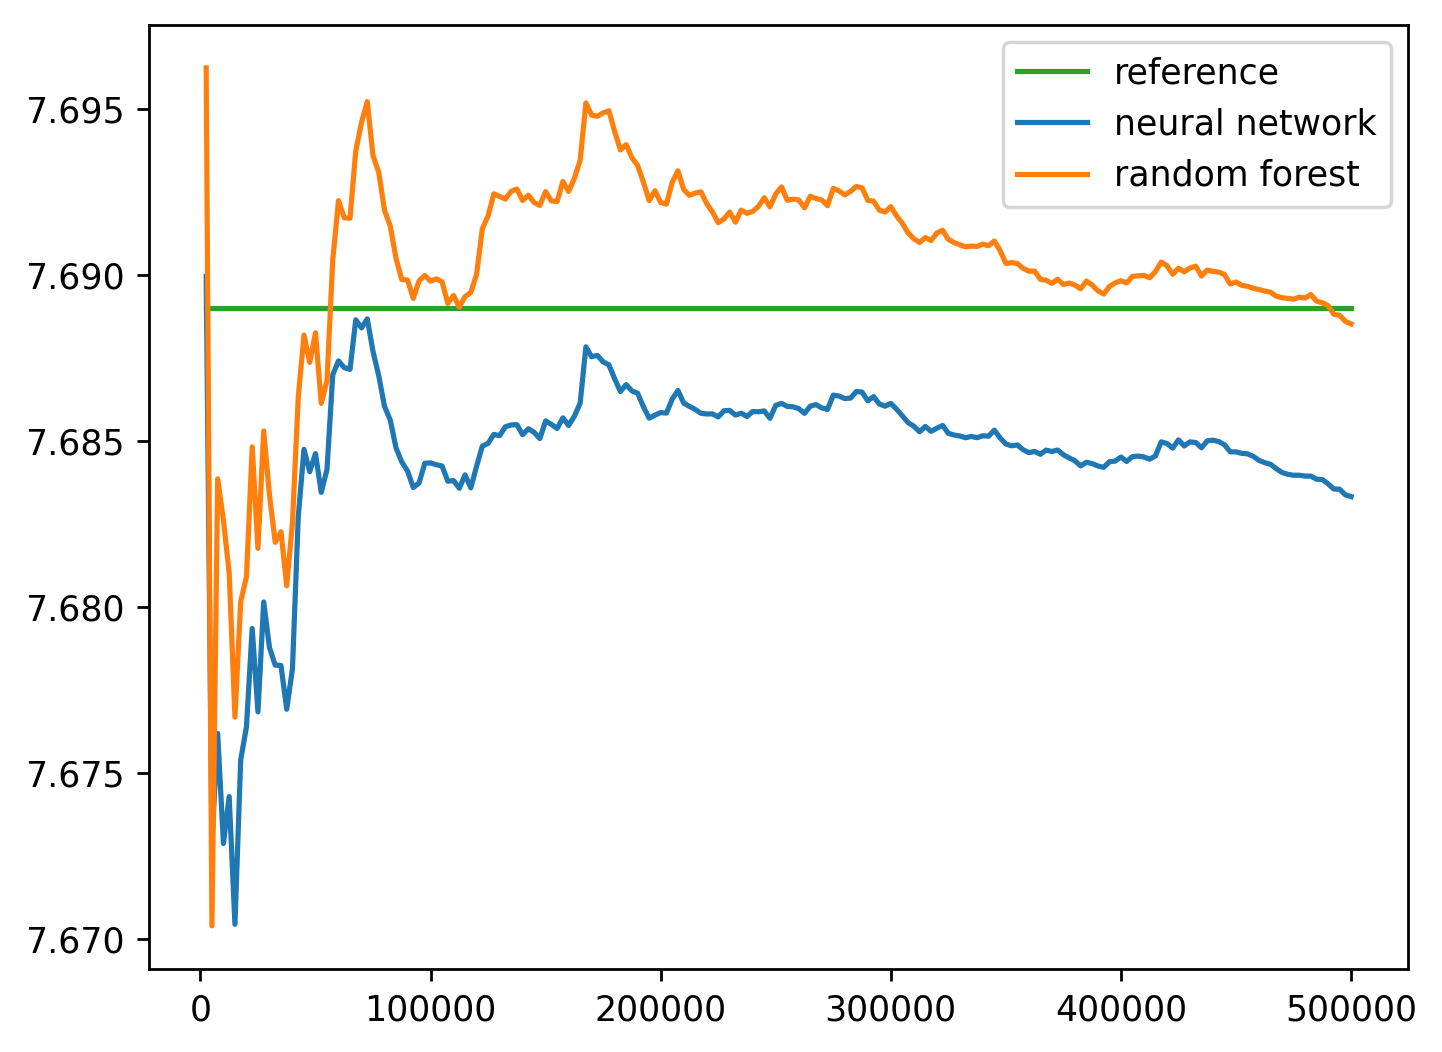

In [28]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),7.689), color='tab:green')
plt.plot(steps,GlueVaR_hat_NN, color='tab:blue')
plt.plot(steps,GlueVaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

Plots showing the fit of the random forest and the neural network. The $x$-axes show $S_\tau$.

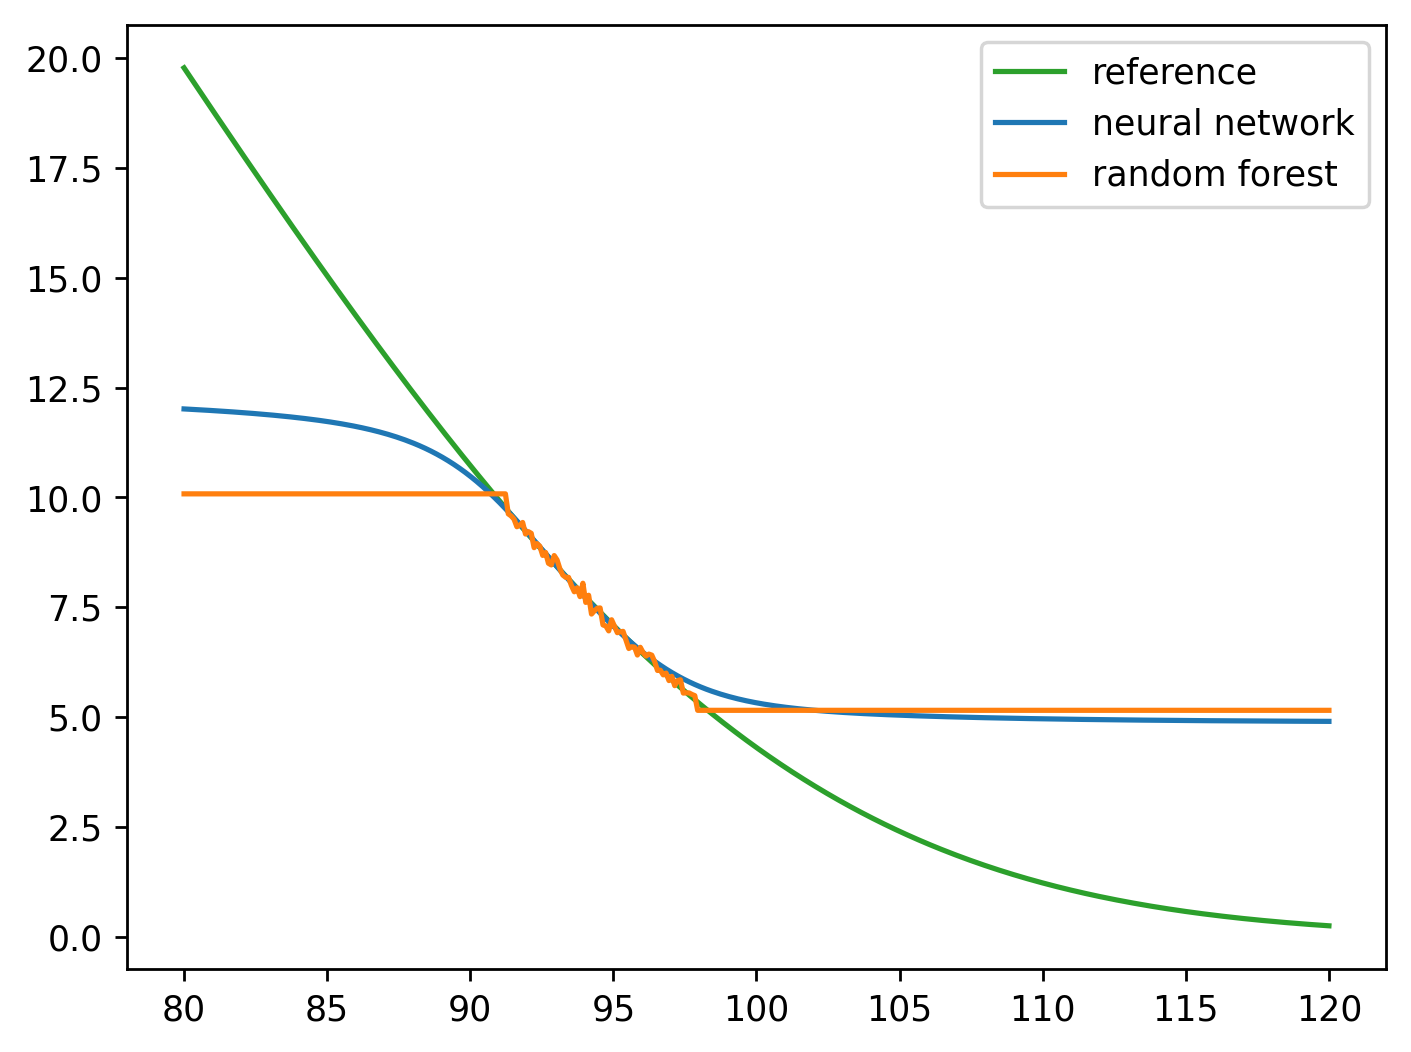

In [29]:
P_T_true = lambda x: K*np.exp(-r*(T-tau)) * stats.norm.cdf(-(np.log(x/K)+(r-0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau))) - x*stats.norm.cdf(-(np.log(x/K)+(r+0.5*sigma**2)*(T-tau))/(sigma*np.sqrt(T-tau)))

x = np.linspace(80, 120, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

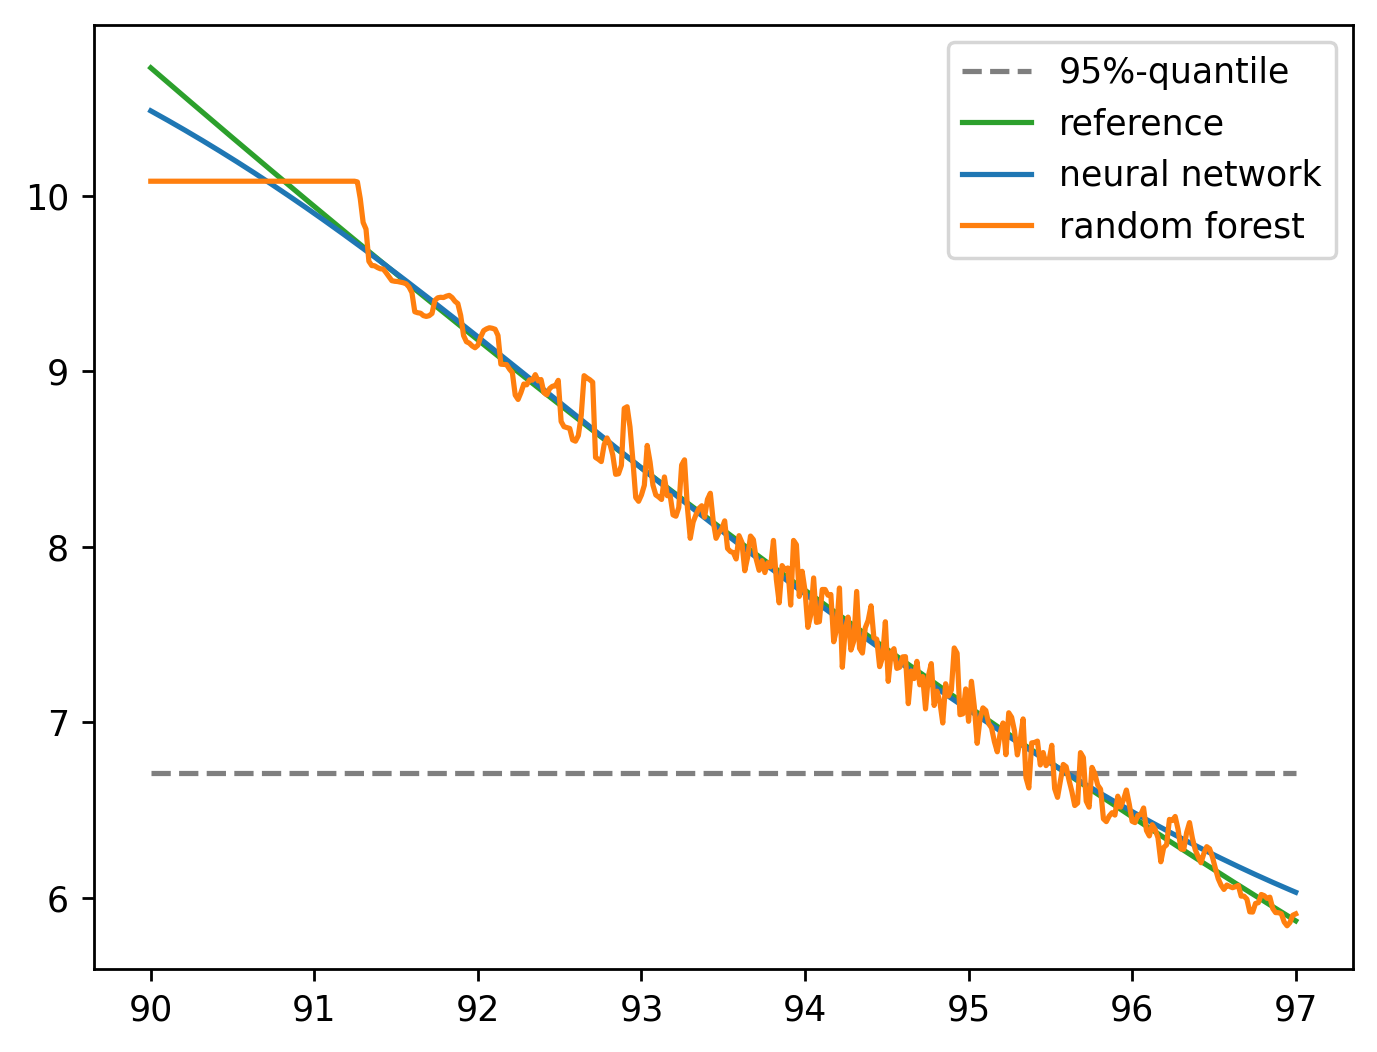

In [30]:
x = np.linspace(90, 97, 400)

plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(x, np.full(len(x),6.7104), color='tab:grey', linestyle='--')
plt.plot(x, P_T_true(x), color='tab:green')
plt.plot(x, model.predict(x)[:,0], color='tab:blue')
plt.plot(x, rfr.predict(x.reshape((-1,1))), color='tab:orange')
plt.legend(['95%-quantile', 'reference', 'neural network', 'random forest'])
plt.show()